In [2]:
from pathlib import Path
import pickle
import pandas as pd

In [3]:
import xgboost
xgboost.__version__

'0.80'

In [4]:
import lightgbm
lightgbm.__version__

'2.2.3'

**TODO: SEE % OF CONFIDENCE FOR EACH MODEL, INSTEAD OF USING 55% FOR ALL**

In [5]:
# configs
TABLES = {
    "condiciones": "CONDICIONES",
    "preguntas": "PREGUNTAS",
    "siniestros": "DSS_SINI_AUTOS_ID",
    "asegurados": "BTT_ASEGURADOS",
    "cif": "tb_cif",
    "vigabt": "VIGABT_POLIZAS",
    #     "investigacion": "INVESTIGACION",  # only to check the results
}

TABLE_COLS = {
    "condiciones": ['CONDICION', 'FEC_ACT', 'NUM_SECU_EXPED', 'USR_ACT', 'VALOR_CONDICION', ],
    "preguntas": ['COD_PREGUNTA', 'FEC_ACT', 'NUM_SECU_EXPED', 'TIPO_EXPED', 'VALOR_PREGUNTA', ],
    "siniestros": ['CATASTROFICO', 'CERRADURA_BAUL', 'CERRADURA_DERECHA', 'CERRADURA_IZQUIERDA', 'CODIGO_BAJA', 'CODIGO_CARATULA', 'CODIGO_REAPERTURA', 'CODIGO_VEHICULO', 'COD_ACT_BENEF', 'COD_CAUSA_SINI', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA', 'COD_POST_TERC', 'COD_RAMO', 'COD_RIES', 'CONDICION_ROBO_EXP50', 'DANOS_MATERIALES', 'DESCRIPCION_TIPO', 'DESCRIPCION_VEHICULO', 'ESTADO_CIVIL', 'ESTADO_CIVIL_TERC', 'ESTAD_VEH_ASEG', 'FALTANTE', 'FECHA_FORMAL', 'FECHA_NAC_ASEG', 'FECHA_NAC_TERC', 'FECHA_SINI', 'FEC_DENU_SINI', 'FIN_INVESTIGACION', 'MCA_COASEG', 'MCA_JUICIO', 'MCA_VIP', 'METRO', 'NUM_SECU_EXPED', 'NUM_SECU_POL', 'OCUPACION_ASEG', 'SEXO', 'SEXO_TERC', 'TELEFONO_TERC', 'TIPO', 'TIPO_EXPED', 'TIPO_LESION', 'TIPO_LESION_MAXIMA', 'TIPO_SINIESTRO', 'USO', ],
    "asegurados": ['CIF_ID', 'COD_EST_CIVIL', 'FECHA_DESDE', 'FECHA_NACIMIENTO', 'SEXO_ASEG', 'TIPO_ACTIVIDAD', ],
    "cif": ['CLIENTE', 'CODIGO_NACION', 'DATECO_TIPO_ACTIVIDAD', 'DOMICILIO_CODIGO_POSTAL', 'HABILITADO', 'ID', ],
    "vigabt": ['CANT_RENOVACION', 'CAPITAL_ACCESORIOS', 'CAPITAL_ASEGURADO_COTIZACION', 'CAPITAL_VEHICULO', 'COD_COBRO', 'COD_COBRO_ANTERIOR', 'COD_POSTAL', 'COD_PROD', 'COD_RAMO', 'COD_RIES', 'COD_ZONA_CASCO', 'COD_ZONA_RC', 'COD_ZONA_ROBO', 'CONV_COMISIONARIO', 'FECHA_PROCESO', 'FECHA_VENC_POL', 'FECHA_VIG_ORIG_POL', 'FECHA_VIG_POL', 'ID', 'MCA_AGRAVANTE', 'MCA_EMPLEADO', 'MCA_MOVIMIENTO', 'MCA_POLIZA_VIP', 'NEGOCIO', 'NUM_SECU_POL', 'PRENDARIO', 'SEGMENTO', ],
}
# file folders
READ_FOLDER = "input_dataset"
READ_FILES_FORMAT = ".csv"
TMP_FOLDER = "tmp"
OUTPUT_FOLDER = "output_dataset"
PRED_FOLDER = "pred_output"

# mapper files
MAPPER_FOLDER = "models/mapper"
MAPPERS = {
    "categorical": "1.2 - dict categorical mappers.pickle",
    "cluster_location": "cod_postal_to_cluster_mapper.pickle",
}
# model files
MODEL_FOLDER = "models"

In [6]:
# 3 columns and models
FILE_COLUMNS = {}
FILE_MODEL = {}

model_path = Path(MODEL_FOLDER)
MODEL = {
    "gte4": '3.2.0.b -  total_condiciones_split_gte_4 with ZONE GROUPS without comp_cond and time_cond',
    "lw4_g1": '3.2.0.lw4.g1 - total_condiciones_split lw4 - recall with zone groups',
    "lw4_g2": '3.2.0.lw4.g2 - 18-5 total_condiciones_split lw4 - recall with zone groups'
}

for k, v in MODEL.items():
    FILE_MODEL[k] = model_path / MODEL[k] / 'model.pickle'
    FILE_COLUMNS[k] = model_path / MODEL[k] / 'columns.pickle'

In [7]:
FILE_MODEL["lw4_g2"].exists() and FILE_MODEL["lw4_g2"].is_file()

True

In [8]:
FILE_COLUMNS.values()

dict_values([PosixPath('models/3.2.0.b -  total_condiciones_split_gte_4 with ZONE GROUPS without comp_cond and time_cond/columns.pickle'), PosixPath('models/3.2.0.lw4.g1 - total_condiciones_split lw4 - recall with zone groups/columns.pickle'), PosixPath('models/3.2.0.lw4.g2 - 18-5 total_condiciones_split lw4 - recall with zone groups/columns.pickle')])

In [17]:
import os
os.path.join("", "Hola")

'Hola'

In [5]:
# in helpers.py
def _load_file_from_pickle(file):
    """Load and return a pickle file."""
    with open(file, "rb") as f:
        o_file = pickle.load(f)
    return o_file

In [71]:
# make list of all useful columns
full_cols = []
for k, v in FILE_COLUMNS.items():
    full_cols.extend(_load_file_from_pickle(v))
full_cols = set(full_cols)
full_cols

{'ANTIG_pol',
 'CANT_RENOVACION',
 'CAPITAL_ACCESORIOS',
 'CAPITAL_ASEGURADO_COTIZACION',
 'CAPITAL_VEHICULO',
 'CIF_ID',
 'CODIGO_BAJA',
 'CODIGO_CARATULA',
 'CODIGO_REAPERTURA',
 'CODIGO_VEHICULO',
 'COD_CAUSA_SINI',
 'COD_COBRO_ANTERIOR',
 'COD_POST_OCURRENCIA',
 'COD_POST_OCURRENCIA_DP_CLUSTER_2019',
 'COD_POST_OCURRENCIA_RC_CLUSTER_2019',
 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
 'COD_POST_POLIZA',
 'COD_POST_POLIZA_DP_CLUSTER_2019',
 'COD_POST_POLIZA_RC_CLUSTER_2019',
 'COD_POST_POLIZA_RT_CLUSTER_2019',
 'COD_POST_TERC',
 'COD_POST_TERC_DP_CLUSTER_2019',
 'COD_PROD',
 'COD_RIES_sini',
 'COD_ZONA_RC',
 'COD_ZONA_ROBO',
 'CONDICION_ROBO_EXP50',
 'CONV_COMISIONARIO',
 'DESCRIPCION_TIPO',
 'DOMICILIO_CODIGO_POSTAL',
 'ESTADO_CIVIL',
 'ESTADO_CIVIL_TERC',
 'ESTAD_VEH_ASEG',
 'FALTANTE',
 'FECHA_SINI_Day',
 'FECHA_SINI_Dayofweek',
 'FECHA_SINI_Dayofyear',
 'FECHA_SINI_Elapsed',
 'FECHA_SINI_Month',
 'FECHA_SINI_Week',
 'MCA_COASEG',
 'MCA_JUICIO',
 'NEGOCIO',
 'OCUPACION_ASEG',
 'PRENDA

In [7]:
# check which model has a column
column = "cant_sini_1y"
for k, v in FILE_COLUMNS.items():
    cols = _load_file_from_pickle(v)
    if column in cols:
        print(k)

# Data Preparation

In [18]:
read_path = Path(READ_FOLDER)
read_path

PosixPath('input_dataset')

## Condiciones

In [25]:
# path to raw file
table_name = "condiciones"
file = read_path / (TABLES[table_name]+READ_FILES_FORMAT)
if not(file.exists() and file.is_file()):
    raise Exception("File: {file} doesn't exists.")

In [26]:
df = pd.read_csv(file, usecols=TABLE_COLS[table_name])  # sep=";"
df.head()

,NUM_SECU_EXPED,CONDICION,VALOR_CONDICION,FEC_ACT,USR_ACT
0,1629215679999,C6,0.0,1/1/2017,SINISWEB
1,1629215679999,C7,0.0,1/1/2017,SINISWEB
2,1629215679999,C8,0.0,1/1/2017,SINISWEB
3,1629215679999,C9,0.0,1/1/2017,SINISWEB
4,1629215689999,C13,0.0,1/1/2017,WEBSPHER


In [23]:
# df["NUM_SECU_EXPED"].astype(str)

In [27]:
id_col = "NUM_SECU_EXPED"
condition = "CONDICION"
value_col = "VALOR_CONDICION"
# getting last repeated record
pv_df = df.pivot_table(index=id_col, columns=condition, values=value_col, aggfunc="last")
#renaming columns
pv_df = pv_df.add_prefix("cond_")
pv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1231015 entries, 516359994 to 1961339499999
Data columns (total 29 columns):
cond_04     108057 non-null float64
cond_05     33644 non-null float64
cond_06     33644 non-null float64
cond_09     34337 non-null float64
cond_11     131464 non-null float64
cond_12     14119 non-null float64
cond_32     74055 non-null float64
cond_37     11644 non-null float64
cond_C1     191102 non-null float64
cond_C10    75339 non-null float64
cond_C11    75339 non-null float64
cond_C12    75339 non-null float64
cond_C13    670758 non-null float64
cond_C14    10667 non-null float64
cond_C15    261730 non-null float64
cond_C16    261730 non-null float64
cond_C17    35174 non-null float64
cond_C18    17275 non-null float64
cond_C19    17275 non-null float64
cond_C2     14229 non-null float64
cond_C20    17275 non-null float64
cond_C21    35174 non-null float64
cond_C3     14229 non-null float64
cond_C4     13069 non-null float64
cond_C5     14229 non-null 

In [28]:
pv_df["total_condicion"] = pv_df.sum(axis=1)
pv_df["es_gte_5"] = pv_df["total_condicion"] >= 5
pv_df.head()

CONDICION,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,...,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,total_condicion,es_gte_5
NUM_SECU_EXPED,,,,,,,,,,,,,,,,,,,,,
516359994,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,1.0,3.0,4.0,False
1762619999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,False
4768809999,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,3.0,3.0,False
6444209999,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,3.0,3.0,False
7529469970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,False


### tmp saving

In [29]:
# save file
tmp_file = Path(TMP_FOLDER)
pv_df.reset_index().to_feather(tmp_file / (TABLES[table_name]+".feather"))

## Preguntas

In [23]:
# path to raw file
table_name = "preguntas"
file = read_path / (TABLES[table_name]+READ_FILES_FORMAT)
if not(file.exists() and file.is_file()):
    raise Exception("File: {file} doesn't exists.")

In [35]:
# python auto sep identifier: , sep=None, engine="python"
df = pd.read_csv(file, usecols=TABLE_COLS[table_name])  # sep=";"
df.head()

,NUM_SECU_EXPED,TIPO_EXPED,COD_PREGUNTA,VALOR_PREGUNTA,FEC_ACT
0,1651669769999,2,9,AMB,7/3/2017
1,1605473309999,50,18,T2,8/3/2017
2,1605473309999,50,15,N,8/3/2017
3,1605473309999,50,37,N,8/3/2017
4,1605473309999,50,22,12000,8/3/2017


In [36]:
id_col = "NUM_SECU_EXPED"
condition = "COD_PREGUNTA"
value_col = "VALOR_PREGUNTA"
# getting oldest repeated record
pv_df = df.pivot_table(index=id_col, columns=condition, values=value_col, aggfunc="last")
#renaming columns
pv_df = pv_df.add_prefix("preg_")
pv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147409 entries, 728135189999 to 1961339499999
Data columns (total 27 columns):
preg_1     2589 non-null object
preg_2     52959 non-null object
preg_3     51926 non-null object
preg_4     54557 non-null object
preg_5     66985 non-null object
preg_6     66985 non-null object
preg_7     54557 non-null object
preg_8     57022 non-null object
preg_9     66985 non-null object
preg_10    54557 non-null object
preg_11    66985 non-null object
preg_12    13041 non-null object
preg_15    62210 non-null object
preg_16    13041 non-null object
preg_18    10807 non-null object
preg_19    10807 non-null object
preg_22    8016 non-null object
preg_24    10808 non-null object
preg_27    13041 non-null object
preg_28    13041 non-null object
preg_30    13041 non-null object
preg_31    65022 non-null object
preg_32    67822 non-null object
preg_33    65022 non-null object
preg_34    34298 non-null object
preg_36    16825 non-null object
preg_37    1074

### tmp saving

In [37]:
# save file
tmp_file = Path(TMP_FOLDER)
pv_df.reset_index().to_feather(tmp_file / (TABLES[table_name]+".feather"))

In [24]:
df = pd.read_feather(tmp_file / (TABLES[table_name]+".feather"))
df.head()

,NUM_SECU_EXPED,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,...,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37
0,728135189999,None,None,None,None,None,None,None,None,None,...,N,07/06/2009 00:00,08/06/2009 00:00,S,None,None,None,None,None,0
1,848582179999,None,NO,N,NH,N,D,91,D,D,...,None,None,None,None,None,None,None,None,None,None
2,858568169999,None,NO,N,NH,N,D,91,D,D,...,None,None,None,None,None,None,None,None,None,None
3,1094129479999,None,None,None,None,S,FA,None,None,AMB,...,None,None,None,None,None,None,None,None,None,None
4,1104460669999,None,None,None,None,None,None,None,None,None,...,N,23/09/2012 00:45,23/09/2012 00:46,S,None,None,None,None,None,None


In [42]:
pv_df.nunique()

COD_PREGUNTA
preg_1         5
preg_2         7
preg_3         2
preg_4         3
preg_5         2
preg_6         5
preg_7        35
preg_8         4
preg_9         6
preg_10        3
preg_11        4
preg_12        6
preg_15        6
preg_16        5
preg_18        5
preg_19        5
preg_22      856
preg_24        2
preg_27    11224
preg_28    11872
preg_30        2
preg_31        2
preg_32        2
preg_33        2
preg_34      743
preg_36     4754
preg_37        5
dtype: int64

## Siniestros

In [85]:
# path to raw file
table_name = "siniestros"
file = read_path / (TABLES[table_name]+READ_FILES_FORMAT)
if not(file.exists() and file.is_file()):
    raise Exception("File: {file} doesn't exists.")

In [86]:
df = pd.read_csv(file, usecols=TABLE_COLS[table_name])  # sep=";"
df.head()

,NUM_SECU_POL,NUM_SECU_EXPED,COD_RAMO,COD_CAUSA_SINI,COD_RIES,FECHA_SINI,FEC_DENU_SINI,TIPO_EXPED,MCA_JUICIO,MCA_COASEG,...,TIPO_LESION_MAXIMA,DANOS_MATERIALES,FIN_INVESTIGACION,MCA_VIP,COD_POST_POLIZA,METRO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CATASTROFICO
0,1571919239999,1629219419999,1,501.0,1,1/1/2017,2/1/2017,3,NaN,NaN,...,NaN,"0,00",NaN,N,9200008.0,N,NaN,NaN,NaN,NO
1,1571919239999,1629219419999,1,501.0,1,1/1/2017,2/1/2017,3,NaN,NaN,...,NaN,"0,00",NaN,N,9200008.0,N,NaN,NaN,NaN,NO
2,1601801009999,1629325139999,1,501.0,1,1/1/2017,2/1/2017,3,NaN,NaN,...,NaN,"0,00",NaN,N,1111000.0,S,NaN,NaN,NaN,NO
3,1594023019999,1629269039999,2,501.0,1,1/1/2017,2/1/2017,3,NaN,NaN,...,NaN,"0,00",NaN,N,1408000.0,S,NaN,NaN,NaN,NO
4,1587199489999,1672678319999,1,501.0,1,1/1/2017,28/4/2017,3,NaN,NaN,...,NaN,"0,00",NaN,S,7620000.0,N,NaN,NaN,NaN,NO


In [87]:
df["NUM_SECU_EXPED"].nunique()

1145005

In [88]:
df.drop_duplicates(subset=["NUM_SECU_EXPED"], keep="last", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145006 entries, 99 to 7517028
Data columns (total 45 columns):
NUM_SECU_POL            1145006 non-null object
NUM_SECU_EXPED          1145005 non-null object
COD_RAMO                1145005 non-null object
COD_CAUSA_SINI          1145005 non-null float64
COD_RIES                1145005 non-null object
FECHA_SINI              1145005 non-null object
FEC_DENU_SINI           1145005 non-null object
TIPO_EXPED              1145006 non-null object
MCA_JUICIO              35155 non-null object
MCA_COASEG              9550 non-null object
CODIGO_REAPERTURA       57738 non-null object
CODIGO_BAJA             1202 non-null object
CODIGO_VEHICULO         1144915 non-null object
DESCRIPCION_VEHICULO    1144914 non-null object
TIPO                    1145002 non-null float64
DESCRIPCION_TIPO        1145002 non-null object
USO                     1145003 non-null object
COD_ACT_BENEF           117986 non-null object
COD_POST_OCURRENCIA     1145000

In [89]:
to_date = ['FECHA_SINI', 'FEC_DENU_SINI', 'FECHA_NAC_ASEG', 'FECHA_NAC_TERC', "FECHA_FORMAL"]
date_format = "%d/%m/%Y"
for col in to_date:
    df[col] = pd.to_datetime(df[col], format=date_format, errors="coerce")

In [90]:
# DO NOT APPLY IN PRODUCTION
# reduce to this year
#df = df[df["FECHA_SINI"].dt.year == 2019]
#df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

In [91]:
df.shape

(1145006, 45)

In [92]:
df["TIPO_EXPED"] = df["TIPO_EXPED"].astype(str)
df["TIPO_EXPED"].unique()

array(['2', '3', '10', '50', '1', '60', '20', '8', '70', '010', '060',
       '002', '003', '001', '050', '020', 'G01', '008', 'G98', 'G97',
       '070', 'G99', '0,00', 'N'], dtype=object)

In [93]:
df["MCA_COASEG"] = df["MCA_COASEG"] == "SI"

In [94]:
df["dist_fformal_fsini"] = (df["FECHA_FORMAL"] - df["FECHA_SINI"]).dt.days
df["dist_fformal_fdenu"] = (df["FECHA_FORMAL"] - df["FEC_DENU_SINI"]).dt.days

In [95]:
df["dias_entre_denu_y_sini"] = (df["FEC_DENU_SINI"] - df["FECHA_SINI"]).dt.days

In [96]:
df["edad_aseg"] = df["FECHA_SINI"].dt.year - df['FECHA_NAC_ASEG'].dt.year
df["edad_terc"] = df["FECHA_SINI"].dt.year - df['FECHA_NAC_TERC'].dt.year

In [97]:
df["existe_FECHA_FORMAL"] = df["FECHA_FORMAL"].notna()

In [98]:
# adding list to vars to drop after finishing the transformation
to_drop = ['FEC_DENU_SINI', 'FECHA_NAC_ASEG', 'FECHA_NAC_TERC', "FECHA_FORMAL", "FIN_INVESTIGACION"]
df.drop(columns=to_drop, inplace=True)

### tmp saving

In [99]:
# fixing export error
to_drop = []
for v in df["NUM_SECU_POL"].unique():
    try:
        float(v)
    except Exception as e:
        print(f"{e}: {v}")
        to_drop.append(v)
to_drop

could not convert string to float: '"': "


['"']

In [100]:
df = df[~df["NUM_SECU_POL"].isin(to_drop)]

In [101]:
# fixing to_feather error
# df["NUM_SECU_EXPED"] = df["NUM_SECU_EXPED"].astype("str")
# df["NUM_SECU_POL"] = df["NUM_SECU_POL"].astype("str")

In [ ]:
# for col in df.select_dtypes("object").columns:
#     df[col] = df[col].astype("str")

In [103]:
# save file
tmp_file = Path(TMP_FOLDER)
df.reset_index(drop=True).to_feather(tmp_file / (TABLES[table_name]+".feather"))

In [58]:
tmp_file = Path(TMP_FOLDER)
df = pd.read_feather(tmp_file / (TABLES[table_name]+".feather"))
df.head()

,NUM_SECU_POL,NUM_SECU_EXPED,COD_RAMO,COD_CAUSA_SINI,COD_RIES,FECHA_SINI,TIPO_EXPED,MCA_JUICIO,MCA_COASEG,CODIGO_REAPERTURA,...,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CATASTROFICO,dist_fformal_fsini,dist_fformal_fdenu,dias_entre_denu_y_sini,edad_aseg,edad_terc,existe_FECHA_FORMAL
0,1612917279999,1629618259999,1,502.0,1,2017-01-01,2,nan,False,nan,...,nan,nan,nan,NO,NaN,NaN,3.0,48.0,NaN,False
1,1612917279999,1629617809999,1,502.0,1,2017-01-01,2,nan,False,nan,...,nan,nan,nan,NO,NaN,NaN,3.0,48.0,NaN,False
2,1612917279999,1629618429999,1,502.0,1,2017-01-01,3,nan,False,nan,...,nan,nan,nan,NO,NaN,NaN,3.0,48.0,NaN,False
3,1613672629999,1629553509999,8,501.0,1,2017-01-01,10,nan,False,nan,...,N,N,N,NO,NaN,NaN,3.0,117.0,NaN,False
4,1607199309999,1629248159999,1,204.0,1,2017-01-01,50,nan,False,nan,...,nan,nan,nan,NO,NaN,NaN,1.0,46.0,NaN,False


In [104]:
df["NUM_SECU_EXPED"].nunique()

1144995

## btt_asegurados

In [27]:
# path to raw file
table_name = "asegurados"
file = read_path / (TABLES[table_name]+READ_FILES_FORMAT)
if not(file.exists() and file.is_file()):
    raise Exception("File: {file} doesn't exists.")

In [28]:
df = pd.read_csv(file, usecols=TABLE_COLS[table_name])  # sep=";"
df.head()

,CIF_ID,COD_EST_CIVIL,FECHA_DESDE,FECHA_NACIMIENTO,SEXO_ASEG,TIPO_ACTIVIDAD
0,5562708.0,SO,8/9/1999,14/10/1977,F,SinDato
1,3808145.0,NaN,16/9/1998,5/11/1968,M,SinDato
2,2465845.0,CA,14/9/1998,5/11/1970,M,EMPL
3,1451142.0,CA,20/12/1995,17/7/1965,M,SinDato
4,840557.0,CA,1/9/1999,17/2/1947,M,INGE


In [7]:
df.drop_duplicates(subset=["CIF_ID"], keep="last", inplace=True)

In [6]:
to_date = ["FECHA_DESDE", "FECHA_NACIMIENTO"]
date_format = "%d/%m/%Y"
for col in to_date:
    df[col] = pd.to_datetime(df[col], format=date_format, errors="coerce")

In [9]:
df["TIPO_ACTIVIDAD"].replace("SinDato", np.nan, inplace=True)

### tmp saving

In [12]:
# save file
tmp_file = Path(TMP_FOLDER)
df.reset_index(drop=True).to_feather(tmp_file / (TABLES[table_name]+".feather"))

## tb_cif

In [22]:
# path to raw file
table_name = "cif"
file = read_path / (TABLES[table_name]+READ_FILES_FORMAT)
if not(file.exists() and file.is_file()):
    raise Exception("File: {file} doesn't exists.")

In [23]:
df = pd.read_csv(file, usecols=TABLE_COLS[table_name], encoding="latin-1", sep=";")
df.head()

,ID,CLIENTE,DOMICILIO_CODIGO_POSTAL,HABILITADO,DATECO_TIPO_ACTIVIDAD,CODIGO_NACION
0,240,NaN,NaN,S,VIAJ,ARGE
1,10386963,S,1765006.0,NaN,EMPL,ARGE
2,10402083,NaN,1133000.0,NaN,NaN,ARGE
3,10401865,NaN,NaN,NaN,NaN,ARGE
4,10401767,NaN,1424000.0,NaN,DIPLO,ARGE


In [24]:
# df.to_csv("cif_.csv", sep=",", encoding="utf-8")


In [31]:
df.rename(columns={"ID": "CIF_ID"}, inplace=True)

In [32]:
df.head()

,CIF_ID,CLIENTE,DOMICILIO_CODIGO_POSTAL,HABILITADO,DATECO_TIPO_ACTIVIDAD,CODIGO_NACION
0,240,NaN,NaN,S,VIAJ,ARGE
1,10386963,S,1765006.0,NaN,EMPL,ARGE
2,10402083,NaN,1133000.0,NaN,NaN,ARGE
3,10401865,NaN,NaN,NaN,NaN,ARGE
4,10401767,NaN,1424000.0,NaN,DIPLO,ARGE


### tmp saving

In [33]:
# save file
tmp_file = Path(TMP_FOLDER)
df.reset_index(drop=True).to_feather(tmp_file / (TABLES[table_name]+".feather"))

## vigabt_polizas

In [76]:
# path to raw file
table_name = "vigabt"
file = read_path / (TABLES[table_name]+READ_FILES_FORMAT)
if not(file.exists() and file.is_file()):
    raise Exception("File: {file} doesn't exists.")

In [77]:
df = pd.read_csv(file, usecols=TABLE_COLS[table_name])
df.head()

,NUM_SECU_POL,COD_ZONA_RC,COD_ZONA_ROBO,COD_RAMO,FECHA_VIG_POL,FECHA_VENC_POL,COD_PROD,COD_COBRO,COD_POSTAL,FECHA_PROCESO,...,COD_RIES,PRENDARIO,NEGOCIO,MCA_POLIZA_VIP,CONV_COMISIONARIO,CANT_RENOVACION,ANTIG,SEGMENTO,COD_ZONA_CASCO,ID
0,1913525329999,1.0,3.0,1,31/3/2019,30/4/2019,23202,TM,1414000,31/3/2019,...,1,N,DEF,S,1000100,74.0,2222.0,ALTO,1.0,10401660.0
1,1921061819999,1.0,1.0,2,6/3/2019,6/4/2019,8430,CC,1602000,31/3/2019,...,1,NaN,NaN,S,NaN,2.0,8239.0,ALTO,1.0,9831.0
2,1756848039999,1.0,1.0,2,26/2/2018,26/3/2018,8430,CC,1602000,28/2/2018,...,1,NaN,NaN,S,NaN,9.0,7866.0,ALTO,1.0,9831.0
3,1720540389999,1.0,1.0,2,26/10/2017,26/11/2017,8430,CC,1602000,31/10/2017,...,1,NaN,NaN,S,NaN,5.0,7743.0,ALTO,1.0,9831.0
4,1665826139999,1.0,3.0,1,6/5/2017,6/6/2017,5660,TM,1428000,30/6/2017,...,1,N,DEF,S,NaN,14.0,7570.0,ALTO,1.0,9831.0


In [78]:
# rename ID for CIF_ID
df.rename(columns={"ID": "CIF_ID"}, inplace=True)

In [79]:
to_date = ['FECHA_PROCESO', 'FECHA_VENC_POL', 'FECHA_VIG_ORIG_POL', 'FECHA_VIG_POL', ]
date_format = "%d/%m/%Y"
for col in to_date:
    df[col] = pd.to_datetime(df[col], format=date_format, errors="coerce")

In [80]:
df.drop_duplicates(subset=["NUM_SECU_POL"], keep="last", inplace=True)

In [81]:
df["cambio_cobro"] = (df["COD_COBRO"] != df["COD_COBRO_ANTERIOR"]) & (df["COD_COBRO_ANTERIOR"].notna())
df["ANTIG_calc"] = (df["FECHA_VIG_POL"] - df["FECHA_VIG_ORIG_POL"]).dt.days

### tmp saving

In [82]:
# fixing to_feather error
df["CONV_COMISIONARIO"] = df["CONV_COMISIONARIO"].astype(str)

In [83]:
# save file
tmp_file = Path(TMP_FOLDER)
df.reset_index(drop=True).to_feather(tmp_file / (TABLES[table_name]+".feather"))

# Merge

In [17]:
tmp_path = Path (TMP_FOLDER)
tmp_path

PosixPath('tmp')

In [18]:
# loading condiciones
file = tmp_path / (TABLES["condiciones"]+".feather")
df_cond = pd.read_feather(file)

In [19]:
df_cond.shape

(1231015, 32)

In [20]:
# changing to string to controll compatibility issues.
# df_cond["NUM_SECU_EXPED"] = df_cond["NUM_SECU_EXPED"].astype(str)

In [21]:
# loading preguntas
file = tmp_path / (TABLES["preguntas"]+".feather")
df_preg = pd.read_feather(file)

In [22]:
# all id columns as str
# df_preg["NUM_SECU_EXPED"] = df_preg["NUM_SECU_EXPED"].astype(str)

In [23]:
# Merging cond + preg
df_int = pd.merge(df_cond, df_preg, on="NUM_SECU_EXPED", how="left", suffixes=("", "_preg"))

In [24]:
df_int["NUM_SECU_EXPED"].nunique()

1231015

In [25]:
set(df_cond) - set(df_int)

set()

In [26]:
df_int.shape, df_cond.shape, df_preg.shape

((1231015, 59), (1231015, 32), (147409, 28))

**Merge vigabt, btt y tb_cif sector**

In [27]:
file = tmp_path / (TABLES["vigabt"]+".feather")
df_vigabt = pd.read_feather(file)

In [28]:
# merging btt asegurados y tbcif
file = tmp_path / (TABLES["asegurados"]+".feather")
df_aseg = pd.read_feather(file)

In [29]:
df_vigabt_aseg = pd.merge(df_vigabt, df_aseg, on="CIF_ID", how="left", suffixes=("_vigabt", "_aseg"))

In [30]:
file = tmp_path / (TABLES["cif"]+".feather")
df_cif = pd.read_feather(file)
df_vigabt_aseg_cif = pd.merge(df_vigabt_aseg, df_cif, on="CIF_ID", how="left", suffixes=("", "_tbcif"))

In [31]:
# loading siniestros
file = tmp_path / (TABLES["siniestros"]+".feather")
df_sini = pd.read_feather(file)
df_sini.drop_duplicates(subset=["NUM_SECU_EXPED"], keep="last", inplace=True)

In [32]:
df_sini["NUM_SECU_EXPED"].nunique() , df_sini["NUM_SECU_EXPED"].nunique() / len(df_sini)

(1144995, 1.0)

In [33]:
# all id columns as str
# df_sini["NUM_SECU_EXPED"] = df_sini["NUM_SECU_EXPED"].astype(str)
# df_sini["NUM_SECU_EXPED"] = df_sini["NUM_SECU_EXPED"].str.replace(".0","")

In [34]:
# all id columns as str
# df_sini["NUM_SECU_POL"] = df_sini["NUM_SECU_POL"].astype(str)
# df_sini["NUM_SECU_POL"] = df_sini["NUM_SECU_POL"].str.replace(".0","")
# df_vigabt_aseg_cif["NUM_SECU_POL"] = df_vigabt_aseg_cif["NUM_SECU_POL"].astype(str)

In [35]:
(df_sini["FECHA_SINI"].dt.month).value_counts(dropna=False)

3     131379
5     115095
4     113334
1     111863
2     101745
10     85429
8      83583
12     83544
11     80863
9      80131
7      79897
6      78132
Name: FECHA_SINI, dtype: int64

In [36]:
df_sini["NUM_SECU_POL"].dtype, df_vigabt_aseg_cif["NUM_SECU_POL"].dtype

(dtype('O'), dtype('int64'))

In [37]:
df_sini["NUM_SECU_POL"] = df_sini["NUM_SECU_POL"].astype("int64")

In [38]:
# merge sini with aseg & cif
df_tmp = pd.merge(df_sini, df_vigabt_aseg_cif, on="NUM_SECU_POL", how="left", suffixes=("_sini", "_vigabt_aseg_cif"))


In [39]:
df_tmp.shape, df_sini["NUM_SECU_EXPED"].nunique()

((1144995, 85), 1144995)

In [40]:
df_tmp[["NUM_SECU_EXPED", "FECHA_SINI"]].head()

,NUM_SECU_EXPED,FECHA_SINI
0,1629618259999,2017-01-01
1,1629617809999,2017-01-01
2,1629618429999,2017-01-01
3,1629553509999,2017-01-01
4,1629248159999,2017-01-01


In [41]:
(df_tmp["FECHA_SINI"].dt.month).value_counts(dropna=False)

3     131379
5     115095
4     113334
1     111863
2     101745
10     85429
8      83583
12     83544
11     80863
9      80131
7      79897
6      78132
Name: FECHA_SINI, dtype: int64

**Merge sini side with cond+preg**

In [42]:
# df_cond["NUM_SECU_EXPED"].dtype, df_sini["NUM_SECU_EXPED"].dtype

In [43]:
# df_sini["NUM_SECU_EXPED"] = df_sini["NUM_SECU_EXPED"].astype(float)

In [44]:
# Merging dropping not founded in DSS_SINIESTROS_AUTOS
# df_merged = pd.merge(df_cond, df_sini, on="NUM_SECU_EXPED", how="left", suffixes=("_cond_side", "_sini_side"))
# print(len(df_cond), len(df_sini), len(df_merged))

In [45]:
df_int["NUM_SECU_EXPED"].dtype, df_tmp["NUM_SECU_EXPED"].dtype

(dtype('int64'), dtype('O'))

In [46]:
df_tmp["NUM_SECU_EXPED"] = df_tmp["NUM_SECU_EXPED"].astype("float")

In [47]:
len(set(df_int["NUM_SECU_EXPED"].unique()).intersection(set(df_tmp["NUM_SECU_EXPED"].unique()))), df_int["NUM_SECU_EXPED"].nunique(), df_tmp["NUM_SECU_EXPED"].nunique()

(1141368, 1231015, 1144995)

In [ ]:
df_int.head()

In [48]:
# Merging dropping not founded in DSS_SINIESTROS_AUTOS
df_merged = pd.merge(df_int, df_tmp, on="NUM_SECU_EXPED", how="left", suffixes=("_cond_side", "_sini_side"))

In [49]:
(df_merged["FECHA_SINI"].dt.month).value_counts(dropna=False)

3.0     130964
5.0     114744
4.0     113004
1.0     111492
2.0     101390
NaN      89647
10.0     85152
8.0      83324
12.0     83301
11.0     80631
9.0      79879
7.0      79631
6.0      77856
Name: FECHA_SINI, dtype: int64

In [50]:
(df_merged[df_merged["FECHA_SINI"].dt.year == 2019]["FECHA_SINI"].dt.month).value_counts(dropna=False)

3    37608
1    35451
4    34658
2    34205
5    33142
Name: FECHA_SINI, dtype: int64

In [149]:
df_int["NUM_SECU_EXPED"].nunique(), df_tmp["NUM_SECU_EXPED"].nunique(), df_merged["NUM_SECU_EXPED"].nunique()

(1231015, 786840, 1231015)

In [47]:
len(set(df_merged["NUM_SECU_EXPED"]) - set(df_int["NUM_SECU_EXPED"]))

0

In [48]:
len(set(df_merged["NUM_SECU_EXPED"]) - set(df_tmp["NUM_SECU_EXPED"]))

681671

In [49]:
# Using zfill to make all 3 len values with 0
# df_merged["TIPO_EXPED"] = df_merged["TIPO_EXPED"].astype("str").str.zfill(3)

In [50]:
# replace None by np.nan
# df_merged.fillna(np.nan, inplace=True)

In [51]:
df_merged.shape

(1231015, 143)

In [52]:
df_merged[["NUM_SECU_EXPED", "FECHA_SINI"]].head()

,NUM_SECU_EXPED,FECHA_SINI
0,516359994,NaT
1,1762619999,NaT
2,4768809999,NaT
3,6444209999,NaT
4,7529469970,NaT


In [51]:
# DO NOT APPLY IN PRODUCTION
# reduce to this year
df_merged = df_merged[df_merged["FECHA_SINI"].dt.year == 2019]
df_merged["FECHA_SINI"].min(), df_merged["FECHA_SINI"].max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2019-05-31 00:00:00'))

In [54]:
(df_merged["FECHA_SINI"].dt.month).value_counts(dropna=False)

3    21567
2    19239
4    18929
1    15210
5    14692
Name: FECHA_SINI, dtype: int64

In [52]:
# save file
save_file = Path(OUTPUT_FOLDER) / "merged.feather"
df_merged.reset_index(drop=True).to_feather(save_file)

# Transform data

In [53]:
# functions from api/helpers.py
import pickle

def _load_file_from_pickle(file):
    """Load and return a pickle file."""
    with open(file, "rb") as f:
        o_file = pickle.load(f)
    return o_file

In [54]:
# functions from api/model.py
def load_model(model_file):
    """Load the dump model."""
    return _load_file_from_pickle(model_file)


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    return _load_file_from_pickle(columns_file)


def load_mapper(mapper_file):
    """Load and return the categorical feature mapper."""
    return _load_file_from_pickle(mapper_file)

In [55]:
# functions from api/model.py
def feature_transformation(dataset, mapper, inplace=False):
    """Map the real value with the transformed value."""
    if inplace:
        df = dataset
    else:
        df = dataset.copy()
    # specific feature format
    df = features_formatter(df)
    df = str_to_bool(df)
    df = str_to_none(df)
    # replace Nulls by np.nan
    # df.fillna(-1, inplace=True)
    # categorical to num transformation
    cat_cols = list(set(mapper.keys()).intersection(df.columns))
    # df = df.astype(float)
    for col in cat_cols:
        unique_values = df.loc[:, col].unique()
        keys = mapper[col].keys()
        new_vals = list(set(unique_values) - keys)
        if(new_vals):
            # replace new values by np.nan
            df.loc[:,col].replace(new_vals, -1, inplace=True)
        df.loc[:,col] = df.loc[:,col].replace(mapper[col])
    df.fillna(-1, inplace=True)
    return df

def str_to_bool(dataset, inplace=False):
    """Replace String False and True by 0 and 1."""
    if inplace:
        df = dataset
    else:
        df = dataset.copy()
    df.replace("True", 1, inplace=True)
    df.replace("False", 0, inplace=True)
    return df


def str_to_none(dataset, inplace=False):
    """Replace string with Null type string to np.nan."""
    if inplace:
        df = dataset
    else:
        df = dataset.copy()
    non_types = ["None", "nan", "np.nan", "NaN"]
    df.replace(non_types, np.nan, inplace=True)
    return df


def features_formatter(dataset, inplace=False):
    """Make specific features transformations."""
    if inplace:
        df = dataset
    else:
        df = dataset.copy()
    # normalizing TIPO_EXPED 
    if "TIPO_EXPED" in df.columns:
        df["TIPO_EXPED"] = df["TIPO_EXPED"].astype("str").str.zfill(3)
    return df

In [56]:
import pandas as pd
import re
import numpy as np


def expandDatetime(data, datefields, drop=True, time=False, inplace=False):
   """Create several features from every datetime column.

   Add new columns to the Dataframe('Year', 'Month', 'Week',
   'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
   'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
   'Is_year_end' and 'Is_year_start') for every feature
   containing the word "Date".

   This method is adapted from fastai.structured.add_datepart.

   Parameters
   ----------
   data: pandas.Dataframe
       The entire working dataset.
   
   datefields: list, optional
       List of datefields to expand.

   drop: boolean, optional
       Determines whether to drop the original datetime columns
       or not.

   time: boolean, optional
       If True adds aditional columns (Hour, Min and Sec).
   
   inplace: boolena, optional (default=False)
       If False modify a new object else modify the object pass
       int data.

   Returns
   -------
   new_data: pandas.Dataframe
       The entire dataframe with the new columns.

   """
   if(inplace):
       new_data = data
   else:
       new_data = data.copy(deep=True)
   fields_list = list(new_data)
   for field in fields_list:
       if field in datefields:
           fld = data[field]
           if not np.issubdtype(fld.dtype, np.datetime64):
               fld = pd.to_datetime(fld, infer_datetime_format=True)
               new_data[field] = fld
           targ_pre = re.sub('[Dd]ate$', '', field)
           attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
                   'Dayofyear', 'Is_month_end', 'Is_month_start',
                   'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
                   'Is_year_start']
           if time:
               attr = attr + ['Hour', 'Minute', 'Second']
           for n in attr:
               new_data[targ_pre + "_" + n] = getattr(fld.dt, n.lower()).astype(float)
           new_data[targ_pre + "_" + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
           if drop:
               new_data.drop(field, axis=1, inplace=True)
   return new_data

In [57]:
output_path = Path(OUTPUT_FOLDER)
file = output_path / "merged.feather"
df = pd.read_feather(file)

In [58]:
(df["FECHA_SINI"].dt.month).value_counts(dropna=False)

3    37608
1    35451
4    34658
2    34205
5    33142
Name: FECHA_SINI, dtype: int64

In [59]:
df["TIPO_EXPED"] = df["TIPO_EXPED"].astype("str").str.zfill(3)
df["TIPO_EXPED"].value_counts(dropna=False)

003    76749
010    67241
060    13241
002    12728
050     2141
020     2123
001      841
Name: TIPO_EXPED, dtype: int64

In [60]:
# creating datetime features
expandDatetime(df, ["FECHA_SINI"], drop=False, time=True, inplace=True).head()

,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,...,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed
0,1905896179999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
1,1905896259999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
2,1905896279999,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
3,1905896299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
4,1905896309999,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800


In [61]:
# antiguedad poliza: rename ANTIG_calc as ANTIG_pol
df.rename(columns={"ANTIG_calc": "ANTIG_pol"}, inplace=True)

In [62]:
"""tmp = df[df["COD_POST_POLIZA"] >= 1000000]
df["COD_POST_POLIZA"] = df["COD_POST_POLIZA"].astype(str)
df["COD_POST_POLIZA"] = df["COD_POST_POLIZA"].str.replace(".0","", regex=False)
# removing last 3 digits
df.loc[tmp.index, "COD_POST_POLIZA"] = df.loc[tmp.index, "COD_POST_POLIZA"].str[:-3]
# returning to float for the mapper
df["COD_POST_POLIZA"] = df["COD_POST_POLIZA"].astype(float)"""

'tmp = df[df["COD_POST_POLIZA"] >= 1000000]\ndf["COD_POST_POLIZA"] = df["COD_POST_POLIZA"].astype(str)\ndf["COD_POST_POLIZA"] = df["COD_POST_POLIZA"].str.replace(".0","", regex=False)\n# removing last 3 digits\ndf.loc[tmp.index, "COD_POST_POLIZA"] = df.loc[tmp.index, "COD_POST_POLIZA"].str[:-3]\n# returning to float for the mapper\ndf["COD_POST_POLIZA"] = df["COD_POST_POLIZA"].astype(float)'

In [63]:
# COD_POST_OCURRENCIA & COD_POST_POLIZA
post_cols = ["COD_POST_POLIZA", "COD_POST_OCURRENCIA", "COD_POST_TERC"]
for col in post_cols:
    tmp = df[df[col] >= 1000000]
    df[col] = df[col].astype(str)
    df[col] = df[col].str.replace(".0","", regex=False)
    # removing last 3 digits
    df.loc[tmp.index, col] = df.loc[tmp.index, col].str[:-3]
    # returning to float for the mapper
    df[col] = df[col].astype(float)

**More complex variables**

In [64]:
def quantity_by_range_dates(df, date_col, id_group, id_count, interval_months=1, new_col="quantity"):
    min_date = df[date_col].min()
    max_date = df[date_col].max()
    num_of_periods = ((max_date - min_date) / (30*interval_months) ).days + 1 # approx. TODO: make it better  
    df[new_col] = df[id_group]
    for i in tqdm(range(num_of_periods)):
        min_period = min_date + pd.DateOffset(months=(interval_months * i))
        max_period = min_period + pd.DateOffset(months=interval_months)
        tmp = df[((df[date_col] >= min_period) & (df[date_col] < max_period))]
        num_uniques = tmp.groupby(id_group)[id_count].nunique()
        mapper = num_uniques.to_dict()
        idxs = tmp[tmp[id_group].isin(num_uniques.index)].index
        df.loc[idxs, new_col] = df.loc[idxs, new_col].replace(mapper)
    # if CIF_ID IS NULL, replace by 0
    df[new_col].fillna(0, inplace=True)
    return df

In [65]:
# cant_pol, not use by any model
# df = quantity_by_range_dates(df, "FECHA_SINI", id_group="CIF_ID", id_count="NUM_SECU_POL", new_col="cant_pol")

In [66]:
# cant_sini_1y, not use by any model
# df = quantity_by_range_dates(df, "FECHA_SINI", id_group="CIF_ID", id_count="NUM_SECU_EXPED", interval_months=12, new_col="cant_sini_1y")

**mappers**

In [67]:
# COD_POSTAL mapper
maper_path = Path(MAPPER_FOLDER)

mapper_file = maper_path / MAPPERS["cluster_location"]
cluster_mapper = load_mapper(mapper_file)
cluster_mapper

{'DP_CLUSTER_2019': {1343: 17.0,
  1344: 17.0,
  1345: 17.0,
  1347: 17.0,
  1348: 17.0,
  1349: 17.0,
  1350: 17.0,
  1351: 17.0,
  1352: 17.0,
  1353: 17.0,
  1354: 17.0,
  1355: 17.0,
  1356: 17.0,
  1357: 17.0,
  1358: 17.0,
  1359: 17.0,
  1360: 17.0,
  1361: 17.0,
  1362: 17.0,
  1363: 17.0,
  1364: 17.0,
  1365: 17.0,
  1366: 17.0,
  1367: 17.0,
  1368: 17.0,
  1370: 17.0,
  1371: 17.0,
  1372: 17.0,
  1373: 17.0,
  1374: 17.0,
  1375: 17.0,
  1376: 17.0,
  1377: 17.0,
  1378: 17.0,
  1379: 17.0,
  1380: 17.0,
  1382: 17.0,
  1383: 17.0,
  1384: 17.0,
  1385: 17.0,
  1386: 17.0,
  1387: 17.0,
  1388: 17.0,
  1389: 17.0,
  1390: 17.0,
  1391: 17.0,
  1392: 17.0,
  1393: 17.0,
  1394: 17.0,
  1395: 17.0,
  1396: 17.0,
  1397: 17.0,
  1398: 17.0,
  1399: 17.0,
  1400: 17.0,
  1401: 17.0,
  1402: 17.0,
  1403: 17.0,
  1404: 17.0,
  1405: 11.0,
  1406: 15.0,
  1407: 25.0,
  1408: 24.0,
  1409: 17.0,
  1410: 17.0,
  1411: 17.0,
  1412: 17.0,
  1413: 17.0,
  1414: 21.0,
  1415: 17.0,
 

In [68]:
cols_to_map = ["COD_POST_POLIZA", "COD_POST_OCURRENCIA", "COD_POST_TERC"]
for col in cols_to_map:
    for k, v in cluster_mapper.items():
        new_col = col + "_" + k
        df[new_col] = df[col]
        df[new_col] = df[new_col].map(v)

In [69]:
maper_path = Path(MAPPER_FOLDER)

mapper_file = maper_path / MAPPERS["categorical"]
categorical_mapper = load_mapper(mapper_file)
categorical_mapper

{'EXISTE_INVEST': {nan: -1, True: 1, False: 0},
 'preg_1': {nan: -1, 'ADD': 0, 'NO': 4, 'ATM': 3, 'ATD': 1, 'ATI': 2},
 'preg_2': {nan: -1,
  'NO': 5,
  'M': 4,
  'A1': 0,
  'PE': 6,
  'B': 2,
  'A2': 1,
  'C': 3},
 'preg_3': {nan: -1, 'N': 0, 'S': 1},
 'preg_4': {nan: -1, 'NH': 2, 'DP': 1, 'DJ': 0},
 'preg_5': {nan: -1, 'N': 0, 'S': 1},
 'preg_6': {nan: -1, 'D': 0, 'FA': 1, 'G': 3, 'PC': 4, 'FR': 2},
 'preg_7': {nan: -1,
  '91': 34,
  '54': 24,
  '47': 19,
  '11': 0,
  '41': 13,
  '71': 29,
  '51': 21,
  '55': 25,
  '46': 18,
  '78': 33,
  '12': 1,
  '42': 14,
  '53': 23,
  '45': 17,
  '33': 10,
  '14': 3,
  '43': 15,
  '44': 16,
  '21': 7,
  '48': 20,
  '18': 6,
  '58': 28,
  '31': 8,
  '38': 12,
  '56': 26,
  '16': 5,
  '13': 2,
  '52': 22,
  '32': 9,
  '34': 11,
  '15': 4,
  '57': 27,
  '73': 31,
  '74': 32,
  '72': 30},
 'preg_8': {nan: -1, 'D': 2, 'SR': 3, 'CM': 0, 'CO': 1},
 'preg_9': {nan: -1, 'D': 2, 'AMB': 0, 'N': 4, 'ASEG': 1, 'OTROS': 5, 'MP': 3},
 'preg_10': {nan: -1, 'D':

In [72]:
cat_cols = set(full_cols).intersection(set(categorical_mapper.keys()))
for col in cat_cols:
    df[col] = df[col].map(categorical_mapper[col])

In [73]:
cond_cols = df.filter(regex="^cond_*").columns
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)

In [74]:
df = df[full_cols].copy()

In [75]:
df.fillna(-1, inplace=True)

### tmp save

In [76]:
# save file
save_file = Path(OUTPUT_FOLDER) / "merged_transformed.feather"
df.to_feather(save_file)

# Predict with multiple models

In [77]:
file = Path(OUTPUT_FOLDER) / "merged_transformed.feather"
df = pd.read_feather(file)
df["prediction"] = np.nan

In [78]:
# keys    
# "gte4"
# "lw4_g1"
# "lw4_g2"

# vars
# FILE_MODEL[k]
# FILE_COLUMNS[k]

In [87]:
to_float = ["CODIGO_VEHICULO", "COD_RIES_sini", "CONDICION_ROBO_EXP50", "CODIGO_REAPERTURA",
            "ESTAD_VEH_ASEG", "CODIGO_BAJA"]
for col in to_float:
    df[col] = df[col].astype(float)

### lge4

In [79]:
# loading model and columns
model_cols = load_columns(FILE_COLUMNS["gte4"])
model = load_model(FILE_MODEL["gte4"])

In [80]:
X = df[(df["total_condicion"] >= 4)][model_cols]

In [83]:
df.loc[X.index, "prediction"] = model.predict_proba(X)[:, -1]

### lwe4 g1

In [84]:
# loading model and columns
model_cols = load_columns(FILE_COLUMNS["lw4_g1"])
model = load_model(FILE_MODEL["lw4_g1"])

In [88]:
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
g1 = [6, 5]

X = df[(df["total_condicion"] < 4) & (df["TIPO_EXPED"].isin(g1))][model_cols]

In [89]:
df.loc[X.index, "prediction"] = model.predict_proba(X)[:, -1]

### lwe4 g2

In [90]:
# loading model and columns
model_cols = load_columns(FILE_COLUMNS["lw4_g2"])
model = load_model(FILE_MODEL["lw4_g2"])

In [91]:
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
g1 = [6, 5]

X = df[(df["total_condicion"] < 4) & (~df["TIPO_EXPED"].isin(g1))][model_cols]

In [92]:
df.loc[X.index, "prediction"] = model.predict_proba(X)[:, -1]

### save predictions

In [93]:
file = Path(OUTPUT_FOLDER) / "merged.feather"
df_pred = pd.read_feather(file)

In [94]:
df_pred["prediction"] = df["prediction"]

In [95]:
save_file = Path(PRED_FOLDER) /  "pred_set.csv"
df_pred.reset_index(drop=True).to_csv(save_file)

# Compare results

In [14]:
file = Path(PRED_FOLDER) /  "pred_set.csv"
df_pred = pd.read_csv(file)
df_pred.head()

,Unnamed: 0,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,...,FECHA_DESDE,FECHA_NACIMIENTO,SEXO_ASEG,TIPO_ACTIVIDAD,CLIENTE,DOMICILIO_CODIGO_POSTAL,HABILITADO,DATECO_TIPO_ACTIVIDAD,CODIGO_NACION,prediction
0,0,516359994,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.432434
1,1,1762619999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002101
2,2,4768809999,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003897
3,3,6444209999,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003897
4,4,7529469970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002101


In [15]:
df_pred["FECHA_SINI"] = pd.to_datetime(df_pred["FECHA_SINI"], format="%Y/%m/%d")
df_pred["mes"] = df_pred["FECHA_SINI"].dt.month

In [16]:
# df_pred = df_pred[(df_pred["mes"] < 5) & (df_pred["FECHA_SINI"].dt.year == 2019)]
# df_pred.to_csv("test results_2019.csv")

In [23]:
df_pred["mes"].value_counts()

KeyError: 'mes'

In [100]:
file = Path(READ_FOLDER)/ "INVESTIGACION.csv"
df_inv = pd.read_csv(file)

/home/seba/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
df_inv.head()

,COD_CIA,COD_RAMO,NUM_SINI,NRO_EXPED,NRO_ORDEN_INV,NRO_INVEST,COD_TALLER,IMPORTE,FECHA_INI_INVEST,FECHA_ENT_INVEST,...,CAUSA_DERIVACION,MOTIVO_DERIVACION,EXISTE_FRAUDE,EXISTE_INHABILITAR,COD_AGEN_DERIV,CESVI_INF_OK,IMPORTE_AHORRADO,SUB_COD_FRAUDE,TIPO_ABOGADO,FECHA_DESISTIMIENTO
0,1,1,60407025569,1,0,28420,NaN,"23182,48",4/1/2017,19/1/2017,...,PAP,SUCU,N,N,6040.0,N,"0,00",NaN,NaN,NaN
1,1,1,53309168069,1,0,28421,NaN,"3300,00",4/1/2017,19/1/2017,...,PAP,SUCU,N,N,5400.0,N,"0,00",NaN,NaN,NaN
2,1,1,50801238217,1,0,28422,NaN,"3300,00",4/1/2017,19/1/2017,...,PAP,SUCU,N,N,5180.0,N,"0,00",NaN,NaN,NaN
3,1,1,53309122129,1,0,28424,NaN,"8211,88",4/1/2017,19/1/2017,...,PAP,SUCU,N,N,6030.0,N,"0,00",NaN,NaN,NaN
4,1,1,53309166378,1,0,28425,NaN,"23580,24",4/1/2017,19/1/2017,...,PAP,SUCU,N,N,5560.0,N,"0,00",NaN,NaN,NaN


In [102]:
df_inv["EXISTE_FRAUDE"].value_counts(dropna=False)

N    17609
S     4859
Name: EXISTE_FRAUDE, dtype: int64

In [103]:
df_pred["real_invest"] = False
df_pred["EXISTE_FRAUDE"] = False
df_pred.head()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f4457a00a58>>
Traceback (most recent call last):
  File "/home/seba/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


,Unnamed: 0,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,...,TIPO_ACTIVIDAD,CLIENTE,DOMICILIO_CODIGO_POSTAL,HABILITADO,DATECO_TIPO_ACTIVIDAD,CODIGO_NACION,prediction,mes,real_invest,EXISTE_FRAUDE
0,0,1905896179999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011044,1,False,False
1,1,1905896259999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000779,1,False,False
2,2,1905896279999,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.412969,1,False,False
3,3,1905896299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001064,1,False,False
4,4,1905896309999,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001759,1,False,False


In [104]:
# invest
df_pred.loc[df_pred["NUM_SECU_EXPED"].isin(df_inv["NUM_SECU_EXPED"]),"real_invest"] = True

In [105]:
# fraude
df_pred.loc[df_pred["NUM_SECU_EXPED"].isin(df_inv[df_inv["EXISTE_FRAUDE"] == "S"]["NUM_SECU_EXPED"]),"EXISTE_FRAUDE"] = True

In [106]:
df_pred["EXISTE_FRAUDE"].value_counts()

False    141285
True        637
Name: EXISTE_FRAUDE, dtype: int64

In [107]:
from sklearn.metrics import confusion_matrix

In [108]:
confusion_matrix(df_pred["EXISTE_FRAUDE"], df_pred["prediction"] > 0.5)

array([[138930,   2355],
       [   120,    517]])

In [109]:
confusion_matrix(df_pred["EXISTE_FRAUDE"], df_pred["es_gte_5"])

array([[139997,   1288],
       [   198,    439]])

In [56]:
# how many investigados
# confusion_matrix(df_pred["real_invest"], df_pred["prediction"] > 0.5)

array([[73091,   625],
       [  365,   864]])

In [113]:
# identified with 55% or more
confusion_matrix(df_pred["EXISTE_FRAUDE"], df_pred["prediction"] > 0.55)

array([[140097,   1188],
       [   159,    478]])

In [114]:
pd.crosstab([df_pred["EXISTE_FRAUDE"], df_pred["TIPO_EXPED"]], [df_pred["es_gte_5"], df_pred["prediction"] > 0.55])

es_gte_5                  False       True       
prediction                False True  False True 
EXISTE_FRAUDE TIPO_EXPED                         
False         1             688     1     5     0
              2           10269     3    81     0
              3           61063     0    10     0
              10          55488     0     2     0
              20           1859     0     0     0
              50           1219    44   352    65
              60           9035   328    26   747
True          1               2     0     0     0
              2               8     1     0     0
              3               3     0     0     0
              10              5     2     0     0
              20              1     2     0     0
              50             24     6     8     3
              60            106    38     2   426

In [111]:
# saving each month
for m in df_pred["mes"].unique():
    tmp = df_pred[df_pred["mes"] == m]
    tmp.reset_index(drop=True).to_csv(f"pred_mes_{m}.csv")

In [27]:
%matplotlib inline
def confusion_matrix_plot(y, y_pred):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    conf_mat = confusion_matrix(y, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt="d")
    plt.show()

In [28]:
for m in df_pred["mes"].unique():
    tmp = df_pred[(df_pred["mes"] == m) & (df_pred["total_condicion"] < 4)]
    print(f"mes: {m}")
    confusion_matrix_plot(tmp["EXISTE_FRAUDE"], tmp["prediction"] > 0.5)

NameError: name 'df_pred' is not defined

mes: 1


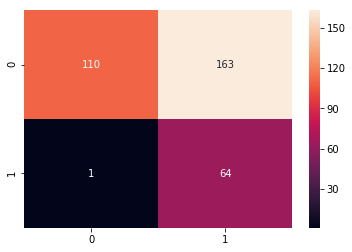

mes: 2


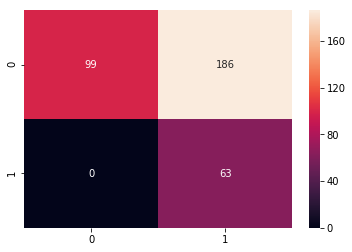

mes: 3


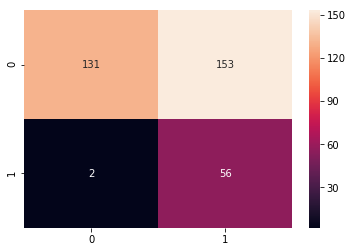

mes: 4


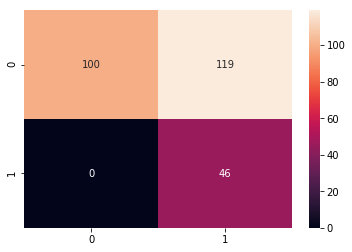

In [67]:
for m in df_pred["mes"].unique():
    tmp = df_pred[(df_pred["mes"] == m) & (df_pred["total_condicion"] >= 4)]
    print(f"mes: {m}")
    confusion_matrix_plot(tmp["EXISTE_FRAUDE"], tmp["prediction"] > 0.5)

mes: 1


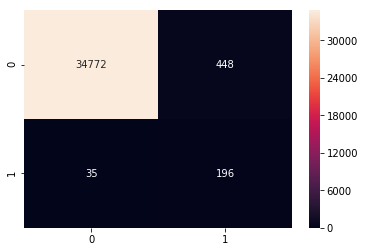

mes: 2


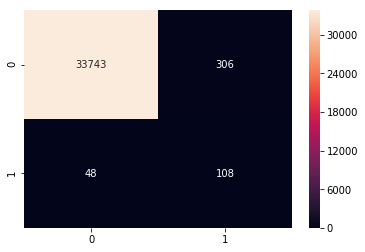

mes: 3


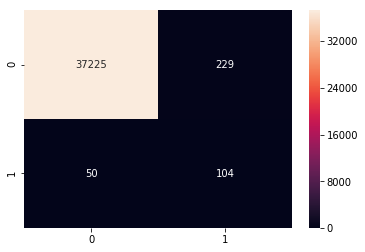

mes: 4


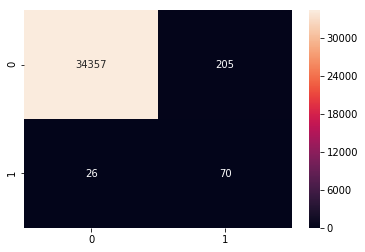

In [116]:
for m in df_pred["mes"].unique():
    tmp = df_pred[(df_pred["mes"] == m)]
    print(f"mes: {m}")
    confusion_matrix_plot(tmp["EXISTE_FRAUDE"], tmp["prediction"] > 0.55)

Tronador mes: 1


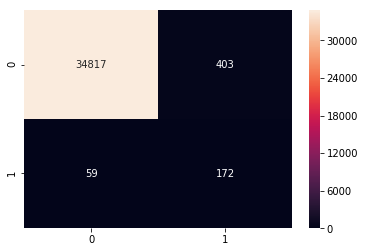

Tronador mes: 2


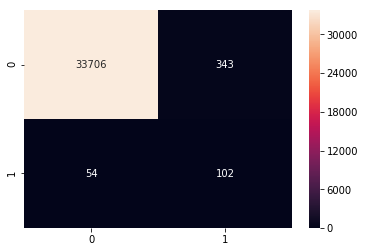

Tronador mes: 3


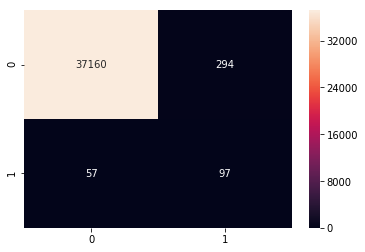

Tronador mes: 4


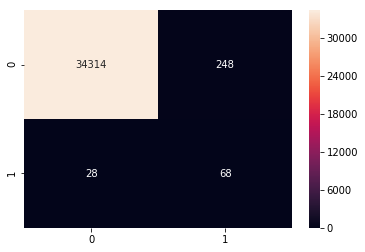

In [117]:
for m in df_pred["mes"].unique():
    tmp = df_pred[df_pred["mes"] == m]
    print(f"Tronador mes: {m}")
    confusion_matrix_plot(tmp["EXISTE_FRAUDE"], tmp["es_gte_5"])

In [103]:
df_pred["mes"].value_counts(dropna=False)

3    21567
2    19239
4    18929
1    15210
Name: mes, dtype: int64

mes: 7


ValueError: zero-size array to reduction operation minimum which has no identity